<html>
    <summary></summary>
         <div> <p></p> </div>
         <div style="font-size: 20px; width: 800px;"> 
              <h1>
               <left>Intro to Bioinformatics in Python: Downloading and Annotating Genomic Sequences.</left>
              </h1>
              <p><left>============================================================================</left> </p>
<pre>Course: BIOM/CBE 480A5, Spring 2025
Instructor: Brian Munsky
Contact Info: munsky@colostate.edu
</pre>
         </div>
    </p>

</html>

<details>
  <summary>Copyright info</summary>

```
Copyright 2024 Brian Munsky

Redistribution and use in source and binary forms, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice, this list of conditions and the following disclaimer in the documentation and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its contributors may be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
```
<details>



In [10]:
# %pip install biopython
# %pip install Bio
import Bio
from Bio import Entrez, SeqIO, pairwise2, AlignIO, Phylo
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.SeqUtils import ProtParam
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import webbrowser
import os
import threading

from Bio import Align
from Bio.Align import Alignment
from pymsaviz import MsaViz

# Function to find ORFs in all frames of a sequence
def find_all_orfs(sequence):
    orf_list = []           # List of all the ORF we find
    for frame in range(3):  # Check each of the three reading frames
        orfs = []           # List of ORFs for the current frame   
        lastStop = frame    # Position of last stop codon.
        for orf in sequence[frame:].translate(to_stop=False).split('*'):     # Translate the curent frame sequence into AA and break up by stop codons
            if len(orf) > 30:                                                # Consider ORFs longer than 50 amino acids
                start = lastStop + orf.find('M') * 3 if 'M' in orf else None # Update start codon position to next M, 
                stop = lastStop + (len(orf))*3 if 'M' in orf else None       # Update stop codon to next '*'
                if start is not None and stop is not None:                   # In the coding region is >30AA
                    orfs.append((start, stop))                                      # Append the start and stop positions for that ORF
            lastStop += len(orf)*3 + 3           # Update the position of the last stop codon
        orf_list.append(orfs)                    # Append the list of ORFs for the current frame
    return orf_list

def pickNLargestORF(orfs,N=5):
    Lengths = []
    Bounds = []
    for frame, orf in enumerate(orfs):
        for start, stop in orf:
            Lengths.append(stop-start)
            Bounds.append([start,stop])
    enumerated_list = list(enumerate(Lengths))
    sortedLengths = sorted(enumerated_list, key=lambda x: abs(x[1]), reverse=True)
    Bounds = [Bounds[index] for index, _ in sortedLengths[:N]]
    return Bounds

# Next, let's find the amino acid sequence for the largest open reading frame from each vaccine
def pickLargestORF(orfs):
    maxLength = 0;
    for frame, orfs in enumerate(orfs):
        for start, stop in orfs:
            if (stop-start)>maxLength:
                largestStart = start
                largestStop = stop
                maxLength = stop-start
            
    return largestStart, largestStop

In [18]:
# (ALIGNMENT) Lets try to align the virus sequence with the BioNTech/Phizer and Moderna vaccines
#      First, lets create the sequences for the two vacines from the following paper: 
#      https://github.com/NAalytics/Assemblies-of-putative-SARS-CoV2-spike-encoding-mRNA-sequences-for-
#          vaccines-BNT-162b2-and-mRNA-1273/blob/main/Assemblies%20of%20putative%20SARS-CoV2-spike-encoding
#          %20mRNA%20sequences%20for%20vaccines%20BNT-162b2%20and%20mRNA-1273.docx.pdf
BNT_Phizer = '''GAGAATAAACTAGTATTCTTCTGGTCCCCACAGACTCAGAGAGAACCCGCCACCATGTTCGTGTTCCTGGTGCTGCTGCCTCTGGTGTCCA
GCCAGTGTGTGAACCTGACCACCAGAACACAGCTGCCTCCAGCCTACACCAACAGCTTTACCAGAGGCGTGTACTACCCCGACAAGGTGTT
CAGATCCAGCGTGCTGCACTCTACCCAGGACCTGTTCCTGCCTTTCTTCAGCAACGTGACCTGGTTCCACGCCATCCACGTGTCCGGCACC
AATGGCACCAAGAGATTCGACAACCCCGTGCTGCCCTTCAACGACGGGGTGTACTTTGCCAGCACCGAGAAGTCCAACATCATCAGAGGCT
GGATCTTCGGCACCACACTGGACAGCAAGACCCAGAGCCTGCTGATCGTGAACAACGCCACCAACGTGGTCATCAAAGTGTGCGAGTTCCA
GTTCTGCAACGACCCCTTCCTGGGCGTCTACTACCACAAGAACAACAAGAGCTGGATGGAAAGCGAGTTCCGGGTGTACAGCAGCGCCAAC
AACTGCACCTTCGAGTACGTGTCCCAGCCTTTCCTGATGGACCTGGAAGGCAAGCAGGGCAACTTCAAGAACCTGCGCGAGTTCGTGTTTA
AGAACATCGACGGCTACTTCAAGATCTACAGCAAGCACACCCCTATCAACCTCGTGCGGGATCTGCCTCAGGGCTTCTCTGCTCTGGAACC
CCTGGTGGATCTGCCCATCGGCATCAACATCACCCGGTTTCAGACACTGCTGGCCCTGCACAGAAGCTACCTGACACCTGGCGATAGCAGC
AGCGGATGGACAGCTGGTGCCGCCGCTTACTATGTGGGCTACCTGCAGCCTAGAACCTTCCTGCTGAAGTACAACGAGAACGGCACCATCA
CCGACGCCGTGGATTGTGCTCTGGATCCTCTGAGCGAGACAAAGTGCACCCTGAAGTCCTTCACCGTGGAAAAGGGCATCTACCAGACCAG
CAACTTCCGGGTGCAGCCCACCGAATCCATCGTGCGGTTCCCCAATATCACCAATCTGTGCCCCTTCGGCGAGGTGTTCAATGCCACCAGA
TTCGCCTCTGTGTACGCCTGGAACCGGAAGCGGATCAGCAATTGCGTGGCCGACTACTCCGTGCTGTACAACTCCGCCAGCTTCAGCACCT
TCAAGTGCTACGGCGTGTCCCCTACCAAGCTGAACGACCTGTGCTTCACAAACGTGTACGCCGACAGCTTCGTGATCCGGGGAGATGAAGT
GCGGCAGATTGCCCCTGGACAGACAGGCAAGATCGCCGACTACAACTACAAGCTGCCCGACGACTTCACCGGCTGTGTGATTGCCTGGAAC
AGCAACAACCTGGACTCCAAAGTCGGCGGCAACTACAATTACCTGTACCGGCTGTTCCGGAAGTCCAATCTGAAGCCCTTCGAGCGGGACA
TCTCCACCGAGATCTATCAGGCCGGCAGCACCCCTTGTAACGGCGTGGAAGGCTTCAACTGCTACTTCCCACTGCAGTCCTACGGCTTTCA
GCCCACAAATGGCGTGGGCTATCAGCCCTACAGAGTGGTGGTGCTGAGCTTCGAACTGCTGCATGCCCCTGCCACAGTGTGCGGCCCTAAG
AAAAGCACCAATCTCGTGAAGAACAAATGCGTGAACTTCAACTTCAACGGCCTGACCGGCACCGGCGTGCTGACAGAGAGCAACAAGAAGT
TCCTGCCATTCCAGCAGTTTGGCCGGGATATCGCCGATACCACAGACGCCGTTAGAGATCCCCAGACACTGGAAATCCTGGACATCACCCC
TTGCAGCTTCGGCGGAGTGTCTGTGATCACCCCTGGCACCAACACCAGCAATCAGGTGGCAGTGCTGTACCAGGACGTGAACTGTACCGAA
GTGCCCGTGGCCATTCACGCCGATCAGCTGACACCTACATGGCGGGTGTACTCCACCGGCAGCAATGTGTTTCAGACCAGAGCCGGCTGTC
TGATCGGAGCCGAGCACGTGAACAATAGCTACGAGTGCGACATCCCCATCGGCGCTGGAATCTGCGCCAGCTACCAGACACAGACAAACAG
CCCTCGGAGAGCCAGAAGCGTGGCCAGCCAGAGCATCATTGCCTACACAATGTCTCTGGGCGCCGAGAACAGCGTGGCCTACTCCAACAAC
TCTATCGCTATCCCCACCAACTTCACCATCAGCGTGACCACAGAGATCCTGCCTGTGTCCATGACCAAGACCAGCGTGGACTGCACCATGT
ACATCTGCGGCGATTCCACCGAGTGCTCCAACCTGCTGCTGCAGTACGGCAGCTTCTGCACCCAGCTGAATAGAGCCCTGACAGGGATCGC
CGTGGAACAGGACAAGAACACCCAAGAGGTGTTCGCCCAAGTGAAGCAGATCTACAAGACCCCTCCTATCAAGGACTTCGGCGGCTTCAAT
TTCAGCCAGATTCTGCCCGATCCTAGCAAGCCCAGCAAGCGGAGCTTCATCGAGGACCTGCTGTTCAACAAAGTGACACTGGCCGACGCCG
GCTTCATCAAGCAGTATGGCGATTGTCTGGGCGACATTGCCGCCAGGGATCTGATTTGCGCCCAGAAGTTTAACGGACTGACAGTGCTGCC
TCCTCTGCTGACCGATGAGATGATCGCCCAGTACACATCTGCCCTGCTGGCCGGCACAATCACAAGCGGCTGGACATTTGGAGCAGGCGCC
GCTCTGCAGATCCCCTTTGCTATGCAGATGGCCTACCGGTTCAACGGCATCGGAGTGACCCAGAATGTGCTGTACGAGAACCAGAAGCTGA
TCGCCAACCAGTTCAACAGCGCCATCGGCAAGATCCAGGACAGCCTGAGCAGCACAGCAAGCGCCCTGGGAAAGCTGCAGGACGTGGTCAA
CCAGAATGCCCAGGCACTGAACACCCTGGTCAAGCAGCTGTCCTCCAACTTCGGCGCCATCAGCTCTGTGCTGAACGATATCCTGAGCAGA
CTGGACCCTCCTGAGGCCGAGGTGCAGATCGACAGACTGATCACAGGCAGACTGCAGAGCCTCCAGACATACGTGACCCAGCAGCTGATCA
GAGCCGCCGAGATTAGAGCCTCTGCCAATCTGGCCGCCACCAAGATGTCTGAGTGTGTGCTGGGCCAGAGCAAGAGAGTGGACTTTTGCGG
CAAGGGCTACCACCTGATGAGCTTCCCTCAGTCTGCCCCTCACGGCGTGGTGTTTCTGCACGTGACATATGTGCCCGCTCAAGAGAAGAAT
TTCACCACCGCTCCAGCCATCTGCCACGACGGCAAAGCCCACTTTCCTAGAGAAGGCGTGTTCGTGTCCAACGGCACCCATTGGTTCGTGA
CACAGCGGAACTTCTACGAGCCCCAGATCATCACCACCGACAACACCTTCGTGTCTGGCAACTGCGACGTCGTGATCGGCATTGTGAACAA
TACCGTGTACGACCCTCTGCAGCCCGAGCTGGACAGCTTCAAAGAGGAACTGGACAAGTACTTTAAGAACCACACAAGCCCCGACGTGGAC
CTGGGCGATATCAGCGGAATCAATGCCAGCGTCGTGAACATCCAGAAAGAGATCGACCGGCTGAACGAGGTGGCCAAGAATCTGAACGAGA
GCCTGATCGACCTGCAAGAACTGGGGAAGTACGAGCAGTACATCAAGTGGCCCTGGTACATCTGGCTGGGCTTTATCGCCGGACTGATTGC
CATCGTGATGGTCACAATCATGCTGTGTTGCATGACCAGCTGCTGTAGCTGCCTGAAGGGCTGTTGTAGCTGTGGCAGCTGCTGCAAGTTC
GACGAGGACGATTCTGAGCCCGTGCTGAAGGGCGTGAAACTGCACTACACATGATGACTCGAGCTGGTACTGCATGCACGCAATGCTAGCT
GCCCCTTTCCCGTCCTGGGTACCCCGAGTCTCCCCCGACCTCGGGTCCCAGGTATGCTCCCACCTCCACCTGCCCCACTCACCACCTCTGC
TAGTTCCAGACACCTCCCAAGCACGCAGCAATGCAGCTCAAAACGCTTAGCCTAGCCACACCCCCACGGGAAACAGCAGTGATTAACCTTT
AGCAATAAACGAAAGTTTAACTAAGCTATACTAACCCCAGGGTTGGTCAATTTCGTGCCAGCCACACCCTGGAGCTAGCA'''
BNT_Phizer = BNT_Phizer.replace("\n", "")

Moderna = '''GGGAAATAAGAGAGAAAAGAAGAGTAAGAAGAAATATAAGACCCCGGCGCCGCCACCATGTTCGTGTTCCTGGTGCTGCTGCCCCTGGTGA
GCAGCCAGTGCGTGAACCTGACCACCCGGACCCAGCTGCCACCAGCCTACACCAACAGCTTCACCCGGGGCGTCTACTACCCCGACAAGGT
GTTCCGGAGCAGCGTCCTGCACAGCACCCAGGACCTGTTCCTGCCCTTCTTCAGCAACGTGACCTGGTTCCACGCCATCCACGTGAGCGGC
ACCAACGGCACCAAGCGGTTCGACAACCCCGTGCTGCCCTTCAACGACGGCGTGTACTTCGCCAGCACCGAGAAGAGCAACATCATCCGGG
GCTGGATCTTCGGCACCACCCTGGACAGCAAGACCCAGAGCCTGCTGATCGTGAATAACGCCACCAACGTGGTGATCAAGGTGTGCGAGTT
CCAGTTCTGCAACGACCCCTTCCTGGGCGTGTACTACCACAAGAACAACAAGAGCTGGATGGAGAGCGAGTTCCGGGTGTACAGCAGCGCC
AACAACTGCACCTTCGAGTACGTGAGCCAGCCCTTCCTGATGGACCTGGAGGGCAAGCAGGGCAACTTCAAGAACCTGCGGGAGTTCGTGT
TCAAGAACATCGACGGCTACTTCAAGATCTACAGCAAGCACACCCCAATCAACCTGGTGCGGGATCTGCCCCAGGGCTTCTCAGCCCTGGA
GCCCCTGGTGGACCTGCCCATCGGCATCAACATCACCCGGTTCCAGACCCTGCTGGCCCTGCACCGGAGCTACCTGACCCCAGGCGACAGC
AGCAGCGGGTGGACAGCAGGCGCGGCTGCTTACTACGTGGGCTACCTGCAGCCCCGGACCTTCCTGCTGAAGTACAACGAGAACGGCACCA
TCACCGACGCCGTGGACTGCGCCCTGGACCCTCTGAGCGAGACCAAGTGCACCCTGAAGAGCTTCACCGTGGAGAAGGGCATCTACCAGAC
CAGCAACTTCCGGGTGCAGCCCACCGAGAGCATCGTGCGGTTCCCCAACATCACCAACCTGTGCCCCTTCGGCGAGGTGTTCAACGCCACC
CGGTTCGCCAGCGTGTACGCCTGGAACCGGAAGCGGATCAGCAACTGCGTGGCCGACTACAGCGTGCTGTACAACAGCGCCAGCTTCAGCA
CCTTCAAGTGCTACGGCGTGAGCCCCACCAAGCTGAACGACCTGTGCTTCACCAACGTGTACGCCGACAGCTTCGTGATCCGTGGCGACGA
GGTGCGGCAGATCGCACCCGGCCAGACAGGCAAGATCGCCGACTACAACTACAAGCTGCCCGACGACTTCACCGGCTGCGTGATCGCCTGG
AACAGCAACAACCTCGACAGCAAGGTGGGCGGCAACTACAACTACCTGTACCGGCTGTTCCGGAAGAGCAACCTGAAGCCCTTCGAGCGGG
ACATCAGCACCGAGATCTACCAAGCCGGCTCCACCCCTTGCAACGGCGTGGAGGGCTTCAACTGCTACTTCCCTCTGCAGAGCTACGGCTT
CCAGCCCACCAACGGCGTGGGCTACCAGCCCTACCGGGTGGTGGTGCTGAGCTTCGAGCTGCTGCACGCCCCAGCCACCGTGTGTGGCCCC
AAGAAGAGCACCAACCTGGTGAAGAACAAGTGCGTGAACTTCAACTTCAACGGCCTTACCGGCACCGGCGTGCTGACCGAGAGCAACAAGA
AATTCCTGCCCTTTCAGCAGTTCGGCCGGGACATCGCCGACACCACCGACGCTGTGCGGGATCCCCAGACCCTGGAGATCCTGGACATCAC
CCCTTGCAGCTTCGGCGGCGTGAGCGTGATCACCCCAGGCACCAACACCAGCAACCAGGTGGCCGTGCTGTACCAGGACGTGAACTGCACC
GAGGTGCCCGTGGCCATCCACGCCGACCAGCTGACACCCACCTGGCGGGTCTACAGCACCGGCAGCAACGTGTTCCAGACCCGGGCCGGTT
GCCTGATCGGCGCCGAGCACGTGAACAACAGCTACGAGTGCGACATCCCCATCGGCGCCGGCATCTGTGCCAGCTACCAGACCCAGACCAA
TTCACCCCGGAGGGCAAGGAGCGTGGCCAGCCAGAGCATCATCGCCTACACCATGAGCCTGGGCGCCGAGAACAGCGTGGCCTACAGCAAC
AACAGCATCGCCATCCCCACCAACTTCACCATCAGCGTGACCACCGAGATTCTGCCCGTGAGCATGACCAAGACCAGCGTGGACTGCACCA
TGTACATCTGCGGCGACAGCACCGAGTGCAGCAACCTGCTGCTGCAGTACGGCAGCTTCTGCACCCAGCTGAACCGGGCCCTGACCGGCAT
CGCCGTGGAGCAGGACAAGAACACCCAGGAGGTGTTCGCCCAGGTGAAGCAGATCTACAAGACCCCTCCCATCAAGGACTTCGGCGGCTTC
AACTTCAGCCAGATCCTGCCCGACCCCAGCAAGCCCAGCAAGCGGAGCTTCATCGAGGACCTGCTGTTCAACAAGGTGACCCTAGCCGACG
CCGGCTTCATCAAGCAGTACGGCGACTGCCTCGGCGACATAGCCGCCCGGGACCTGATCTGCGCCCAGAAGTTCAACGGCCTGACCGTGCT
GCCTCCCCTGCTGACCGACGAGATGATCGCCCAGTACACCAGCGCCCTGTTAGCCGGAACCATCACCAGCGGCTGGACTTTCGGCGCTGGA
GCCGCTCTGCAGATCCCCTTCGCCATGCAGATGGCCTACCGGTTCAACGGCATCGGCGTGACCCAGAACGTGCTGTACGAGAACCAGAAGC
TGATCGCCAACCAGTTCAACAGCGCCATCGGCAAGATCCAGGACAGCCTGAGCAGCACCGCTAGCGCCCTGGGCAAGCTGCAGGACGTGGT
GAACCAGAACGCCCAGGCCCTGAACACCCTGGTGAAGCAGCTGAGCAGCAACTTCGGCGCCATCAGCAGCGTGCTGAACGACATCCTGAGC
CGGCTGGACCCTCCCGAGGCCGAGGTGCAGATCGACCGGCTGATCACTGGCCGGCTGCAGAGCCTGCAGACCTACGTGACCCAGCAGCTGA
TCCGGGCCGCCGAGATTCGGGCCAGCGCCAACCTGGCCGCCACCAAGATGAGCGAGTGCGTGCTGGGCCAGAGCAAGCGGGTGGACTTCTG
CGGCAAGGGCTACCACCTGATGAGCTTTCCCCAGAGCGCACCCCACGGAGTGGTGTTCCTGCACGTGACCTACGTGCCCGCCCAGGAGAAG
AACTTCACCACCGCCCCAGCCATCTGCCACGACGGCAAGGCCCACTTTCCCCGGGAGGGCGTGTTCGTGAGCAACGGCACCCACTGGTTCG
TGACCCAGCGGAACTTCTACGAGCCCCAGATCATCACCACCGACAACACCTTCGTGAGCGGCAACTGCGACGTGGTGATCGGCATCGTGAA
CAACACCGTGTACGATCCCCTGCAGCCCGAGCTGGACAGCTTCAAGGAGGAGCTGGACAAGTACTTCAAGAATCACACCAGCCCCGACGTG
GACCTGGGCGACATCAGCGGCATCAACGCCAGCGTGGTGAACATCCAGAAGGAGATCGATCGGCTGAACGAGGTGGCCAAGAACCTGAACG
AGAGCCTGATCGACCTGCAGGAGCTGGGCAAGTACGAGCAGTACATCAAGTGGCCCTGGTACATCTGGCTGGGCTTCATCGCCGGCCTGAT
CGCCATCGTGATGGTGACCATCATGCTGTGCTGCATGACCAGCTGCTGCAGCTGCCTGAAGGGCTGTTGCAGCTGCGGCAGCTGCTGCAAG
TTCGACGAGGACGACAGCGAGCCCGTGCTGAAGGGCGTGAAGCTGCACTACACCTGATAATAGGCTGGAGCCTCGGTGGCCTAGCTTCTTG
CCCCTTGGGCCTCCCCCCAGCCCCTCCTCCCCTTCCTGCACCCGTACCCCCGTGGTCTTTGAATAAAGTCTGAGTGGGCGGCAAAAAAAAA'''

Moderna = Moderna.replace("\n", "")

In [11]:
#(PRELIMINARIES) Let's download the COVID19 virus sequence from NCBI
# Provide your email for accessing NCBI
Entrez.email = "brian.munsky@colostate.edu"  # Insert your email here

def get_genbank(accession_number):
    handle = Entrez.efetch(db="nucleotide", id=accession_number, rettype="gb", retmode="text")
    record = SeqIO.read(handle, "genbank")
    handle.close()
    return record

corona_virus = get_genbank("MN908947")

# Exploring Evolutionary History of Multiple Sequences
To understand the evolutionary history of sequences, we can make phylogenetic trees. Let's try that with our BLAST results from before.

In [12]:
def makeTree(alignedFile):
    # read our alignment file.
    align = AlignIO.read(alignedFile, 'fasta')

    # define sequence distance metric
    calculator = DistanceCalculator('identity')
    dm  = calculator.get_distance(align)

    # construct tree
    constructor = DistanceTreeConstructor()
    return constructor.upgma(dm), dm

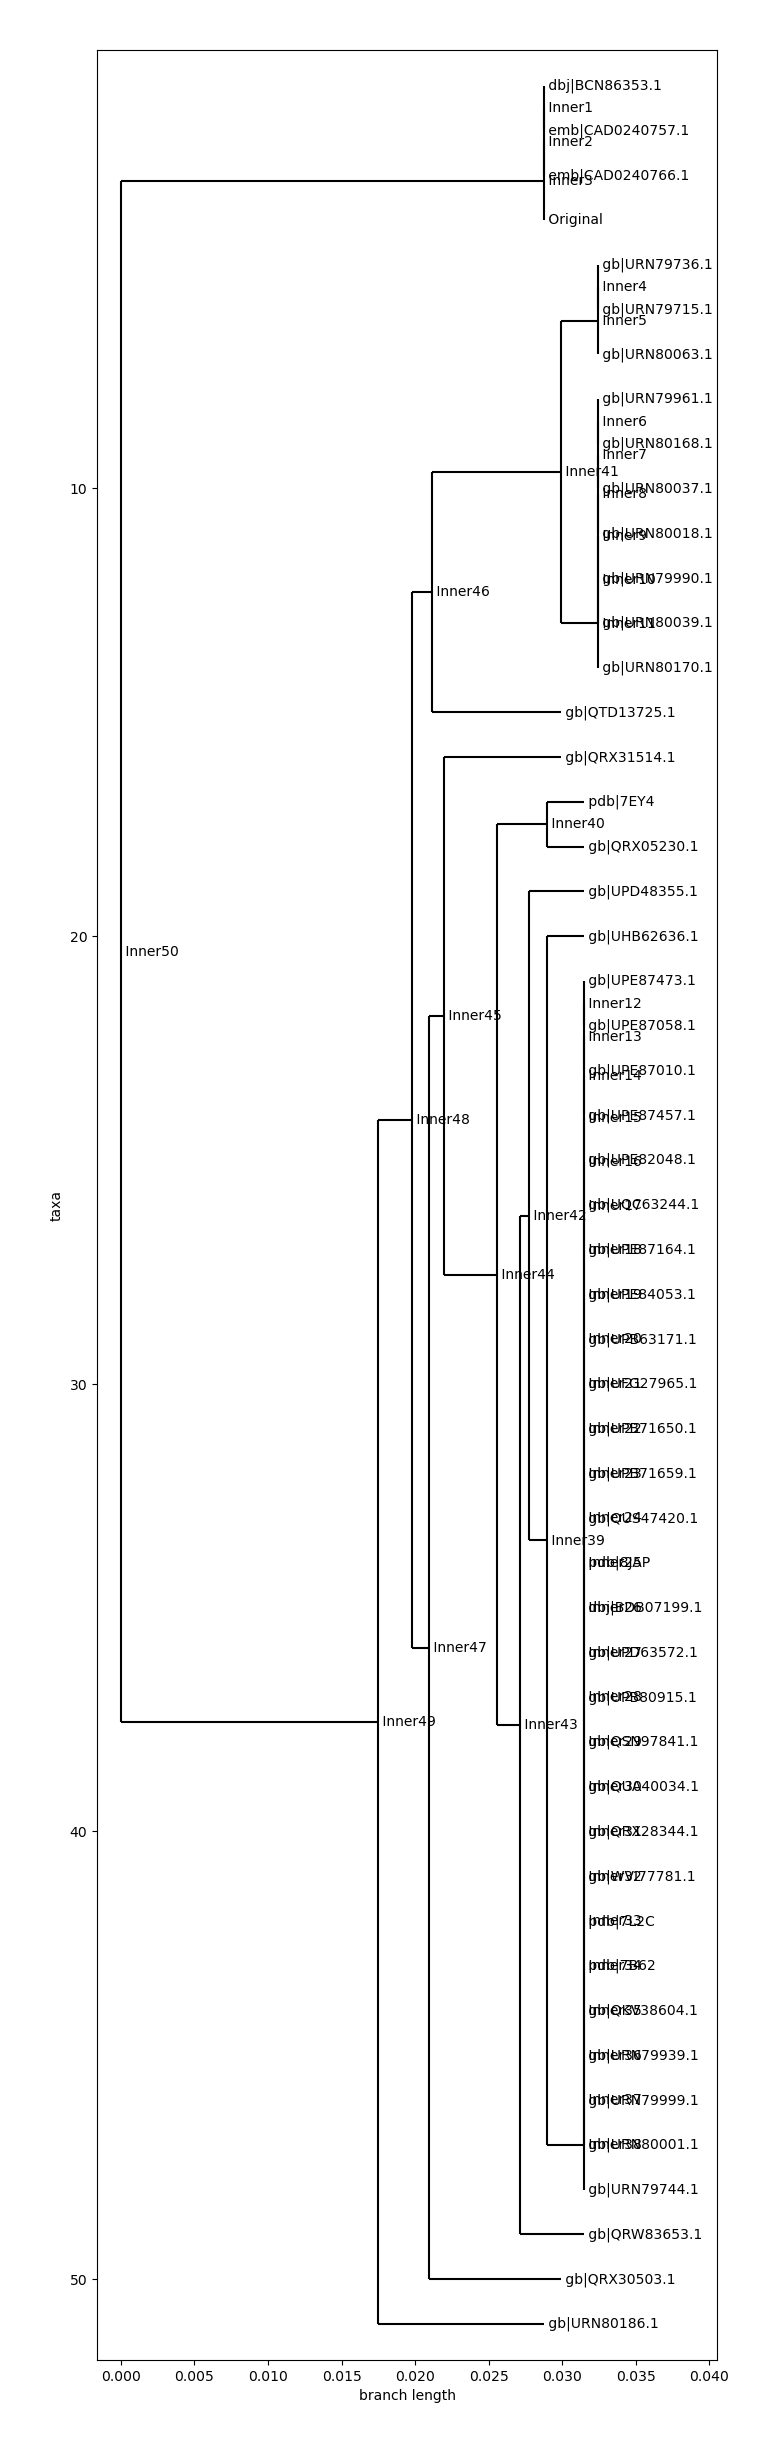

                                                   , dbj|BCN86353.1
                                                   |
                                                   | emb|CAD0240757.1
                                                   |
  _________________________________________________| emb|CAD0240766.1
 |                                                 |
 |                                                 | Original
 |
 |                                                        , gb|URN79736.1
 |                                                        |
 |                                                    ____| gb|URN79715.1
 |                                                   |    |
 |                                                   |    | gb|URN80063.1
 |                                                   |
 |                                                   |    , gb|URN79961.1
 |                                                   |    |
 |                                   

In [13]:
# We will use the alignment file that we found in the last lesson:
alignedFile = "blast_file_aligned.afa"

tree, dm = makeTree(alignedFile)

# plot tree
fig, ax = plt.subplots(figsize=(8, 30))  # Adjust size as needed
Phylo.draw(tree,axes=ax)
Phylo.draw_ascii(tree)

In [14]:
# The numerical distances can be found in the distance matrix "dm"
print(dm)

print(f'The phylogenetic distance between {dm.names[0]} and {dm.names[4]} is {dm[0,4]}')
print(f'The phylogenetic distance between {dm.names[1]} and {dm.names[4]} is {dm[1,4]}')

gb|URN80186.1   0.000000
gb|QRX30503.1   0.025000    0.000000
gb|QRW83653.1   0.020000    0.015000    0.000000
gb|URN79744.1   0.015000    0.010000    0.005000    0.000000
gb|URN80001.1   0.015000    0.010000    0.005000    0.000000    0.000000
gb|URN79999.1   0.015000    0.010000    0.005000    0.000000    0.000000    0.000000
gb|URN79939.1   0.015000    0.010000    0.005000    0.000000    0.000000    0.000000    0.000000
gb|QKV38604.1   0.015000    0.010000    0.005000    0.000000    0.000000    0.000000    0.000000    0.000000
pdb|7B62    0.015000    0.010000    0.005000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
pdb|7L2C    0.015000    0.010000    0.005000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
gb|WVI77781.1   0.015000    0.010000    0.005000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000    0.000000
gb|QRX28344.1   0.015000    0.010000    0.005000    0.000000    0.000000 

### 3.A) Explore different Covid variants.

Let's focus our analysis a little more closely onto some famous variants that were in the news during the early stages of the COVID19 pandemic:

In [15]:
# Create a dictionary to map the sequence IDs to the sequence names
variantDict = {"wuhan":'MN908947',
            "delta":'OK091006',
            "beta":'MZ433432',
            "alpha":'MZ773928',
            "omicron":'PP028445',
            "OP208953":'OP208953',
            "MT628218":'MT628218'}

sequenceEntry = {}
for variant in variantDict:
    print(f"Downloading {variant} variant using accession number {variantDict[variant]}")
    sequenceEntry[variant] = get_genbank(variantDict[variant])
    # sequenceEntry.append(get_genbank(variantDict[variant]))

Let's also add the original Moderna vaccine to the mix so we can see what sequence it was most similar to.

In [20]:
Moderna_orf_positions = find_all_orfs(Seq(Moderna))


Next, we will use a loop to write the protein sequences of all the different variants into a single FASTA file.  Note how we are including both the name and accession number varantDict[variant] and the translated sequence in each entry. 

In [26]:
variant_file_fasta = "covid_variants.fa"
with open(variant_file_fasta, "w") as handle:
    for variant in variantDict:
        # Find and record the third largest ORF for each sequence
        orf_positions = find_all_orfs(sequenceEntry[variant].seq)
        longestORFbounds = pickNLargestORF(orf_positions,5)
        proteinOfInterest = sequenceEntry[variant].seq[longestORFbounds[2][0]:].translate(to_stop=True)
        handle.write(f">{variant}:{variantDict[variant]}\n{proteinOfInterest}\n")
    startMod, stopMod = pickLargestORF(Moderna_orf_positions)
    proteinOfInterest = Seq(Moderna[startMod:stopMod]).translate(to_stop=True)
    handle.write(f">Moderna\n{proteinOfInterest}\n")


In [27]:
# Now that we have a fasta file, we can run MUSCLE again to 
# compute and plot its alignment:
alignedFile = "covid_variants_aligned.afa"

# Use a terminal command (bash) to run MUSCLE in to align the sequences.        
bashCommand = "muscle -align " + variant_file_fasta + " -output " + alignedFile
os.system(bashCommand)


muscle 5.3.osx64 [-]  34.4Gb RAM, 12 cores
Built Nov 11 2024 08:21:37
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

[align covid_variants.fa]
Input: 8 seqs, avg length 1278, max 1282, min 1273

00:00 2.6Mb   100.0% Derep 8 uniques, 0 dupes
00:00 2.6Mb  CPU has 12 cores, running 12 threads
00:00 1.3Gb   100.0% Calc posteriors
00:01 1.5Gb   100.0% UPGMA5         
00:01 1.5Gb   100.0% Consistency (1/2)
00:01 1.6Gb   100.0% Consistency (2/2)
00:01 1.6Gb   100.0% Refining         


0

In [28]:
# Make and save an alignment figure
mv = MsaViz(alignedFile, wrap_length=150, show_count=True)
mv.savefig("Variant_Alignment.png")

# Load the image
img = mpimg.imread('Variant_Alignment.png')

# Display the image
fig = plt.figure(figsize=(80, 80), dpi=200)
plt.imshow(img)
plt.axis('off')  # Hide axis
plt.show()

In [29]:
# Compute the phylogenetic tree using our previous function:
tree = makeTree(alignedFile)
# plot tree
Phylo.draw_ascii(tree[0])

                                      _____________________ Moderna
                                     |
  ___________________________________|    _________________ beta:MZ433432
 |                                   |   |
 |                                   |___|       __________ delta:OK091006
 |                                       |  ____|
 |                                       | |    |         , MT628218:MT628218
_|                                       |_|    |_________|
 |                                         |              | wuhan:MN908947
 |                                         |
 |                                         |_______________ alpha:MZ773928
 |
 |                       __________________________________ OP208953:OP208953
 |______________________|
                        |__________________________________ omicron:PP028445



In [30]:
# The numerical distances can be found in the distance matrix "dm"
print(tree[1])

print(f'The phylogenetic distance between {tree[1].names[0]} and {tree[1].names[4]} is {tree[1][0,4]}')
print(f'The phylogenetic distance between {tree[1].names[1]} and {tree[1].names[4]} is {tree[1][1,4]}')

omicron:PP028445    0.000000
alpha:MZ773928  0.046022    0.000000
OP208953:OP208953   0.024961    0.028081    0.000000
beta:MZ433432   0.049142    0.014041    0.030421    0.000000
Moderna 0.055382    0.017161    0.035881    0.017161    0.000000
wuhan:MN908947  0.046802    0.008580    0.027301    0.008580    0.008580    0.000000
MT628218:MT628218   0.046022    0.007800    0.026521    0.007800    0.009360    0.000780    0.000000
delta:OK091006  0.046022    0.014821    0.028081    0.015601    0.017161    0.008580    0.007800    0.000000
    omicron:PP028445    alpha:MZ773928  OP208953:OP208953   beta:MZ433432   Moderna wuhan:MN908947  MT628218:MT628218   delta:OK091006
The phylogenetic distance between omicron:PP028445 and Moderna is 0.055382215288611536
The phylogenetic distance between alpha:MZ773928 and Moderna is 0.01716068642745705


Want to add some more variants to the plot.  See here for a much larger tree:
https://www.bv-brc.org/view/VariantLineage/#view_tab=phlyogeny